In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import random

import tensorflow as tf

import pickle
import os, sys, time
import shap

In [2]:
def create_data(data_path, normalization = False, scaler = None):
    # read data from file
    dataFrame = pd.read_excel(data_path, sheet_name='Data')

    # Preprocess features: substitute categorial strings with numbers
    string_to_number_set = []
    for col in dataFrame:
        unique_strings = dataFrame.loc[dataFrame[col].apply(lambda x: isinstance(x, str)), col].unique()
        string_to_number = {s: i + 1 for i, s in enumerate(unique_strings)}
        dataFrame[col] = dataFrame[col].replace(string_to_number)
        string_to_number_set.append(string_to_number)
    all_info = dataFrame.iloc[:, 4:32]
    features = all_info.iloc[:, :16]
    targets = all_info.iloc[:, 23:28]
    features_header = features.columns.values
    
    features.columns = features_header

    # Find columns with NaN
    slump_data = pd.concat([features, targets.iloc[:, 0]], axis=1).dropna(axis=0, how='any').values
    comp_str_data = pd.concat([features, targets.iloc[:, 1]], axis=1).dropna(axis=0, how='any').values
    split_str_data = pd.concat([features, targets.iloc[:, 2]], axis=1).dropna(axis=0, how='any').values
    chloride_data = pd.concat([features, targets.iloc[:, 3]], axis=1).dropna(axis=0, how='any').values
    carbon_data = pd.concat([features, targets.iloc[:, 4]], axis=1).dropna(axis=0, how='any').values

    # Put all the information in collections
    X = [
        slump_data[:,:-1],
        comp_str_data[:,:-1],
        split_str_data[:,:-1],
        chloride_data[:,:-1],
        carbon_data[:,:-1]
    ]

    Y = [
        slump_data[:, -1:],
        comp_str_data[:, -1:],
        split_str_data[:, -1:],
        chloride_data[:, -1:],
        carbon_data[:, -1:]
    ]

    # Normalization
    if normalization == True:
        if scaler == None:
            scaler = StandardScaler()
        scaler.fit_transform(features)
        X = _normalize_list(X, scaler)

    return X, Y, scaler, features_header

def dataPreparation(X, Y, test_size, random_state, D_contra=True):
    assert len(X) == len(Y)
    T = len(Y)  # number of tasks
    O = [y.shape[1] for y in Y]  # number of outputs for every task
    D = [x.shape[1] for x in X]
    if D_contra == True:
        assert len(list(set(D))) == 1
        D = list(set(D))
        D = D[0] # dimension of feature vector

    X_train = []; Y_train = []; X_test = []; Y_test = []
    for i in range(T):
        x_train, x_test, y_train, y_test = _split_for_single_task(X[i], Y[i], test_size, random_state)
        X_train.append(x_train)
        Y_train.append(y_train)
        X_test.append(x_test)
        Y_test.append(y_test)

    return X_train, Y_train, X_test, Y_test, T, O, D

def _normalize_list(list, scaler):
    normalized_list = []
    for ele in list:
        normed_ele = scaler.transform(ele)
        normalized_list.append(normed_ele)

    return normalized_list

def _split_for_single_task(x, y, test_size, random_state):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    assert x_train.shape[0] == y_train.shape[0] \
           and x_test.shape[0] == y_test.shape[0] \
           and x_train.shape[1] == x_test.shape[1] \
           and y_train.shape[1] == y_test.shape[1]

    return x_train, x_test, y_train, y_test

In [3]:
H1 = 64
H2 = 32
trace_proportion = 0.1
epoch_number = 8000
unify = False
data_dir = 'C:/Users/leeno/Desktop/Dataspell/4102/'
data_name = 'allData.xls'
save_model_path = 'C:/Users/leeno/Desktop/Dataspell/4102/Check'
save_pic_path = 'C:/Users/leeno/Desktop/Dataspell/4102/Check/Pic'
traceNormalizationMethod = 'LAF' # Three methods: 'LAF', 'Tucker', and 'TT'
data_path = os.path.join(data_dir, data_name)
X_all, y_all, scaler, features_header = create_data(data_path, normalization=True)
if unify == False: # Set dimensions of features here!
    X_usage = [pd.DataFrame(X_all[i], columns=features_header) for i in range(len(X_all))]
    y_usage = y_all
    X_usage[0] = X_all[0][:,:-4]
X_train, Y_train, X_test, Y_test, T, O, D = dataPreparation(X_usage, y_usage, test_size=0.2, random_state=42, D_contra=False)

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


In [9]:
X_test

[array([[-0.36814748, -0.65209165,  1.22693177, ...,  0.49050598,
          0.4700913 ,  0.01344774],
        [-0.36814748, -0.65209165,  0.4588981 , ...,  0.49050598,
          1.66345194,  0.26056286],
        [-0.36814748, -0.65209165,  0.97748494, ..., -1.59951602,
          0.02901345,  0.49784953],
        ...,
        [-0.36814748,  0.71258761, -0.9655746 , ..., -0.55450502,
          0.93567348, -1.24318879],
        [-0.36814748,  0.16671591, -0.9655746 , ..., -0.55450502,
          0.93567348, -1.24318879],
        [-0.36814748,  0.78082158, -0.9655746 , ...,  0.22925323,
          0.82540402, -0.44287279]]),
       ASTM type 1 ordinary Portland Cement content (kg/m^3)  \
 582                                           -0.368147       
 901                                           -0.368147       
 907                                           -0.368147       
 1753                                          -0.368147       
 1463                                          -0.368

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.python.framework import function, dtypes


Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
@function.Defun(dtypes.float32, dtypes.float32)
def nuclear_norm_grad(x, dy):
    _, U, V = tf.svd(x, full_matrices=False, compute_uv=True)
    grad = tf.matmul(U, tf.transpose(V))
    return dy * grad


@function.Defun(dtypes.float32, grad_func=nuclear_norm_grad)
def nuclear_norm(x):
    sigma = tf.svd(x, full_matrices=False, compute_uv=False)
    norm = tf.reduce_sum(sigma)
    return norm


def TensorUnfold(A, k):
    tmp_arr = np.arange(A.get_shape().ndims)
    A = tf.transpose(A, [tmp_arr[k]] + np.delete(tmp_arr, k).tolist())
    shapeA = A.get_shape().as_list()
    A = tf.reshape(A, [shapeA[0], np.prod(shapeA[1:])])
    return A


def TensorTraceNorm(X, method='Tucker'):
    shapeX = X.get_shape().as_list()
    dimX = len(shapeX)
    if method == 'Tucker':
        re = [nuclear_norm(i) for i in [TensorUnfold(X, j) for j in range(dimX)]]
    elif method == 'TT':
        re = [nuclear_norm(i) for i in
              [tf.reshape(X, [np.prod(shapeX[:j]), np.prod(shapeX[j:])]) for j in range(1, dimX)]]
    elif method == 'LAF':
        re = [nuclear_norm(TensorUnfold(X, -1))]
    return tf.stack(re)

In [6]:
sess = tf.InteractiveSession()
# a total of 12 variables including 6 weight matrices and 6 bias vectors
# Here we use "TensorTraceNorm" to get the trace norm of shareable layer's parameter (tensor)
########################################################################################################################
# Input to hidden 1
W_input_to_hidden_1 = [tf.Variable(tf.truncated_normal(shape=[d, H1])) for d in D]
b_input_to_hidden_1 = [tf.Variable(tf.zeros(shape=[H1])) for _ in range(T)]

# Hidden 1 to hidden 2
W_input_to_hidden_2 = tf.Variable(tf.truncated_normal(shape=[H1, H2, T]))
Trace_norm_input_to_hidden = TensorTraceNorm(W_input_to_hidden_2, traceNormalizationMethod)
W_input_to_hidden_2 = [W_input_to_hidden_2[:,:,i] for i in range(T)]

# Nothing changes for bias terms or unshared parameters
b_input_to_hidden_2 = [tf.Variable(tf.zeros(shape=[H2])) for _ in range(T)]
W_hidden_to_output = [tf.Variable(tf.truncated_normal(shape=[H2, o])) for o in O]
b_hidden_to_output = [tf.Variable(tf.zeros(shape=[o])) for o in O]

# Build the network as usual
X_placeholder = [tf.placeholder(tf.float32, shape=[None, d]) for d in D]
Y_placeholder = [tf.placeholder(tf.float32, shape=[None, o]) for o in O]
# Add test placeholders
X_test_placeholder = [tf.placeholder(tf.float32, shape=[None, d]) for d in D]
Y_test_placeholder = [tf.placeholder(tf.float32, shape=[None, o]) for o in O]

# Calculate train predictions
Y_hat = [tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(x,w0,b0)),w1,b1)),w2,b2)
         for x,w0,b0,w1,b1,w2,b2 in zip(X_placeholder, W_input_to_hidden_1, b_input_to_hidden_1, W_input_to_hidden_2, \
                                        b_input_to_hidden_2, W_hidden_to_output, b_hidden_to_output)]
# Calculate test predictions
Y_test_hat = [tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(x,w0,b0)),w1,b1)),w2,b2)
              for x,w0,b0,w1,b1,w2,b2 in zip(X_test_placeholder, W_input_to_hidden_1, b_input_to_hidden_1, W_input_to_hidden_2, \
                                             b_input_to_hidden_2, W_hidden_to_output, b_hidden_to_output)]

train_feed_dict = dict(list(zip(X_placeholder, X_train)) + list(zip(Y_placeholder, Y_train)))
test_feed_dict = dict(list(zip(X_test_placeholder, X_test)) + list(zip(Y_test_placeholder, Y_test)))

# Calculate MSE
MSE = [tf.reduce_mean(tf.squared_difference(y, y_hat)) for y, y_hat in zip(Y_placeholder,Y_hat)]
test_MSE = [tf.reduce_mean(tf.squared_difference(y, y_hat)) for y, y_hat in zip(Y_test_placeholder, Y_test_hat)]

# Here we add trace norm as part of losses
loss = tf.reduce_mean(MSE) + trace_proportion * tf.reduce_sum(Trace_norm_input_to_hidden)
test_loss = tf.reduce_mean(test_MSE) + trace_proportion * tf.reduce_sum(Trace_norm_input_to_hidden)

opt = tf.train.AdamOptimizer(learning_rate=0.003)
train = opt.minimize(loss)

# Train the model
init_op = tf.global_variables_initializer() # Workaround: https://github.com/tensorflow/tensorflow/issues/6804
sess.run(init_op)

best_loss = np.inf
best_epoch = 0
saver = tf.train.Saver(max_to_keep=1)
for epoch in range(epoch_number):
    train.run(feed_dict=train_feed_dict)
    train_loss_value = loss.eval(feed_dict=train_feed_dict)
    test_loss_value = test_loss.eval(feed_dict=test_feed_dict)
    if test_loss_value < best_loss:
        if epoch > 5000 and epoch - best_epoch > 10:
            saver.save(sess, save_model_path)
        best_loss = test_loss_value
        best_epoch = epoch
    if epoch % 1000 == 0:
        print("Epoch:", epoch)
        print("Train loss:", train_loss_value)
        print("Test loss:", test_loss_value)
        print("Best loss:", best_loss)

Epoch: 0
Train loss: 3534.4478
Test loss: 3540.8354
Best loss: 3540.8354
Epoch: 1000
Train loss: 1158.7673
Test loss: 1132.8196
Best loss: 1132.8196
Epoch: 2000
Train loss: 656.41754
Test loss: 641.50323
Best loss: 641.50323
Epoch: 3000
Train loss: 330.0096
Test loss: 346.53247
Best loss: 346.53247
Epoch: 4000
Train loss: 149.8704
Test loss: 179.04033
Best loss: 179.04033
Epoch: 5000
Train loss: 69.53656
Test loss: 126.598816
Best loss: 126.42969
Epoch: 6000
Train loss: 40.96136
Test loss: 117.854996
Best loss: 115.61101
Epoch: 7000
Train loss: 27.424538
Test loss: 122.777115
Best loss: 115.61101


INFO:tensorflow:Restoring parameters from C:/Users/leeno/Desktop/Dataspell/4102/Check


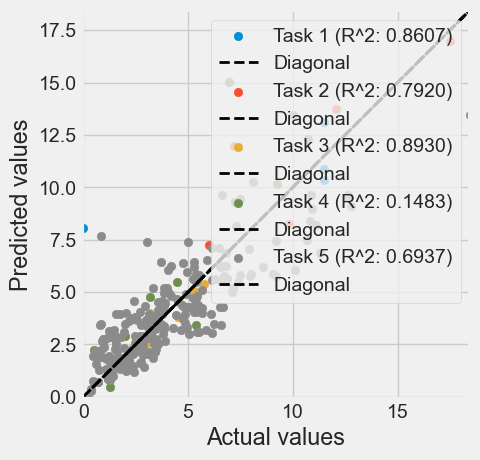

In [7]:
# Start validating
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, save_model_path)

# Calculate predicted values after training
predicted_values = sess.run(Y_test_hat, feed_dict=test_feed_dict)

# Plot actual vs predicted values with R^2 in the legend
for i in range(T):
    X_plot_values = Y_test[i] 
    Y_plot_values = predicted_values[i] 
    # Calculate R^2 score for each task
    r2 = r2_score(X_plot_values, Y_plot_values)
    # Plot scatters
    plt.scatter(X_plot_values, Y_plot_values, label=f"Task {i + 1} (R^2: {r2:.4f})")
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    # Calculate axis limits
    min_limit = min(X_plot_values.min(), Y_plot_values.min())
    max_limit = max(X_plot_values.max(), Y_plot_values.max())
    # Plot a diagonal
    plt.plot([min_limit, max_limit], [min_limit, max_limit], 'k--', lw=2, label="Diagonal")
    # Set axis limits and equal aspect ratio
    plt.xlim(min_limit, max_limit)
    plt.ylim(min_limit, max_limit)
    plt.gca().set_aspect('equal', adjustable='box')
    # assert X_plot_values.shape == Y_plot_values.shape
    # for j in range(X_plot_values.shape[0]):
    #     print(f"Task {i} Sample {j}: actual:{X_plot_values[j]},predicted:{Y_plot_values[j]}")
    plt.legend()
    # plt.savefig(save_pic_path + 'task_' + str(i) + '.png')
    # plt.savefig(save_pic_path + 'task_' + str(i) + '_R2=' + str(r2) + '.png')
plt.show()

X does not have valid feature names, but StandardScaler was fitted with feature names
Using 387 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


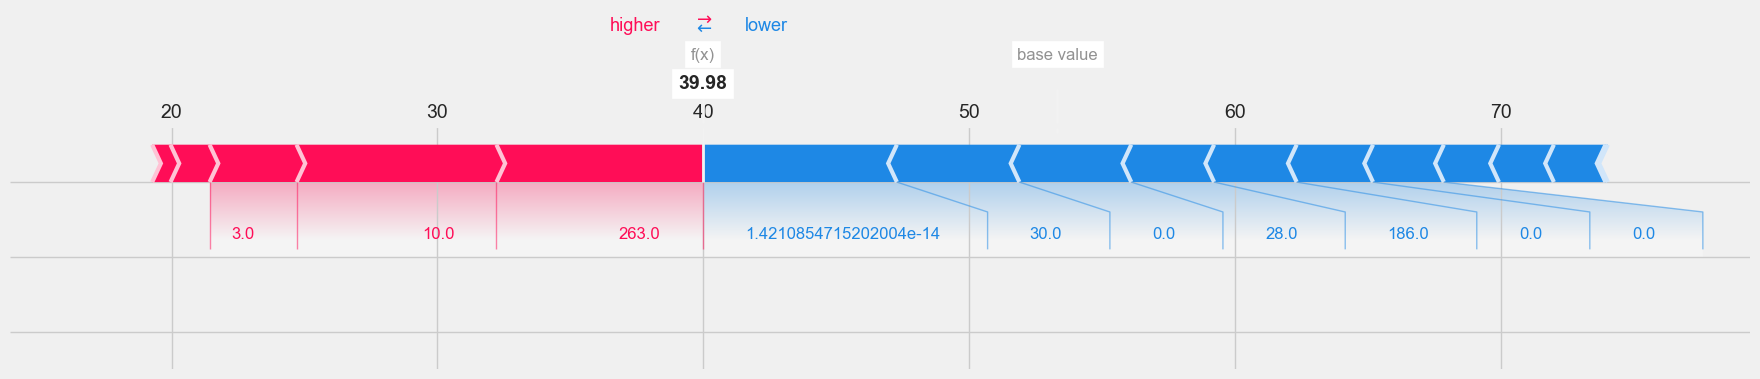

In [8]:
task_num = 1
sample_num = 9
feature_num = 4
x = X_test_placeholder[task_num]
w0 = W_input_to_hidden_1[task_num]
b0 = b_input_to_hidden_1[task_num]
w1 = W_input_to_hidden_2[task_num]
b1 = b_input_to_hidden_2[task_num]
w2 = W_hidden_to_output[task_num]
b2 = b_hidden_to_output[task_num]

def exF(X):
    X = scaler.transform(X)
    test_explain_feed_dict = {X_test_placeholder[task_num]: X}
    Y_test_explain = tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(tf.nn.sigmoid(tf.nn.xw_plus_b(x,w0,b0)),w1,b1)),w2,b2)
    predicted_values = sess.run(Y_test_explain, feed_dict=test_explain_feed_dict)
    predicted_values = predicted_values.flatten()
    return predicted_values

X_test_task = scaler.inverse_transform(X_test[task_num])
explainer = shap.KernelExplainer(exF, X_test_task)

## Force plot (One sample)
shap_values = explainer.shap_values(X_test_task[sample_num], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_test_task[sample_num], show=False, matplotlib=True)
plt.show()

In [9]:
explained_sample_df = pd.DataFrame(X_test_task[sample_num])
shap_values_df = pd.DataFrame(shap_values)
features_header_df = pd.DataFrame(features_header)
explain_result = pd.concat([features_header_df, explained_sample_df, shap_values_df], axis=1)

  0%|          | 0/387 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

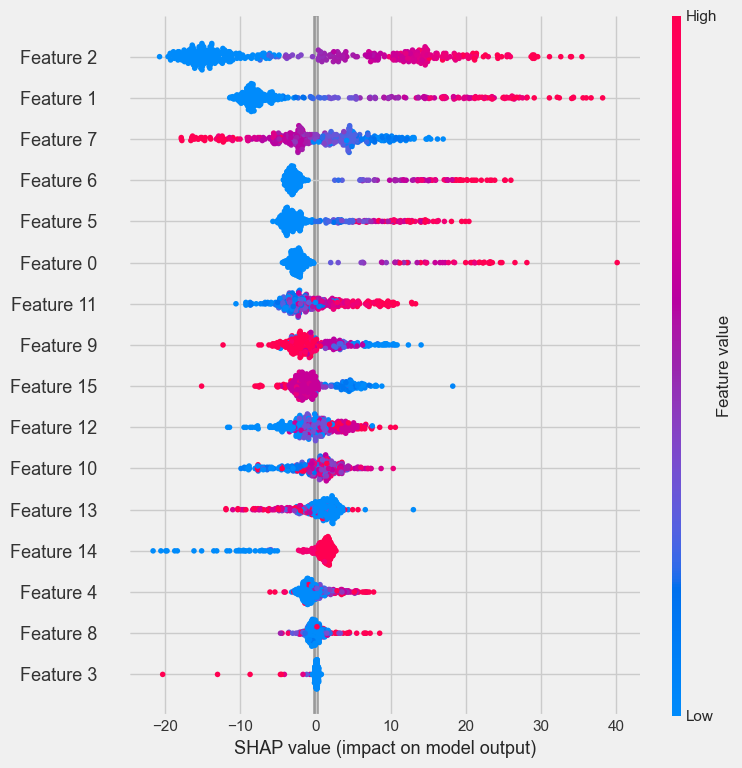

In [10]:
## Summary plot
shap_values = explainer.shap_values(X_test_task)
shap.summary_plot(shap_values, X_test_task)
plt.show()

In [ ]:
## Waterfall plot, beeswarm plot, heatmap, scatter and histogram plot
X_test_task_df = pd.DataFrame(X_test_task)
med = X_test_task_df.median().values.reshape((1,X_test_task.shape[1]))
explainer = shap.Explainer(exF, med)
shap_values = explainer(X_test_task)
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)
shap.plots.heatmap(shap_values)
shap.plots.scatter(shap_values)
shap.plots.scatter(shap_values[:,0])

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale